In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
!mkdir -p data
!wget -O data/chest_xray.zip https://zenodo.org/records/18090336/files/chest_xray.zip

--2025-12-31 01:42:05--  https://zenodo.org/records/18090336/files/chest_xray.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 137.138.52.235, 188.185.43.153, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914770894 (872M) [application/octet-stream]
Saving to: ‘data/chest_xray.zip’

data/chest_xray.zip 100%[===================>] 872.39M  3.76MB/s    in 3m 7s   

2025-12-31 01:45:13 (4.65 MB/s) - ‘data/chest_xray.zip’ saved [914770894/914770894]



In [5]:
!unzip data/chest_xray.zip -d data/
!ls data/chest_xray
!ls data/chest_xray/train
!ls data/chest_xray/test

Archive:  data/chest_xray.zip
   creating: data/chest_xray/
  inflating: data/chest_xray/.DS_Store  
   creating: data/chest_xray/test/
  inflating: data/chest_xray/test/.DS_Store  
   creating: data/chest_xray/test/NORMAL/
  inflating: data/chest_xray/test/NORMAL/IM-0001-0001.jpeg  
  inflating: data/chest_xray/test/NORMAL/IM-0003-0001.jpeg  
  inflating: data/chest_xray/test/NORMAL/IM-0005-0001.jpeg  
  inflating: data/chest_xray/test/NORMAL/IM-0006-0001.jpeg  
  inflating: data/chest_xray/test/NORMAL/IM-0007-0001.jpeg  
  inflating: data/chest_xray/test/NORMAL/IM-0009-0001.jpeg  
  inflating: data/chest_xray/test/NORMAL/IM-0010-0001.jpeg  
  inflating: data/chest_xray/test/NORMAL/IM-0011-0001-0001.jpeg  
  inflating: data/chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg  
  inflating: data/chest_xray/test/NORMAL/IM-0011-0001.jpeg  
  inflating: data/chest_xray/test/NORMAL/IM-0013-0001.jpeg  
  inflating: data/chest_xray/test/NORMAL/IM-0015-0001.jpeg  
  inflating: data/chest_xray/test/

In [6]:
import os
import random
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [7]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

In [8]:
DATA_DIR = "data/chest_xray"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")

In [9]:
def get_transforms(img_size):
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        )
    ])

    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        )
    ])
    return train_transform, test_transform

In [10]:
IMG_SIZE_B0 = 224
train_tf_b0, test_tf_b0 = get_transforms(IMG_SIZE_B0)

train_dataset_b0 = ImageFolder(TRAIN_DIR, transform=train_tf_b0)
test_dataset_b0  = ImageFolder(TEST_DIR, transform=test_tf_b0)

In [11]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader_b0 = DataLoader(
    train_dataset_b0,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_loader_b0 = DataLoader(
    test_dataset_b0,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

In [12]:
IMG_SIZE_B3 = 300
train_tf_b3, test_tf_b3 = get_transforms(IMG_SIZE_B3)

train_dataset_b3 = ImageFolder(TRAIN_DIR, transform=train_tf_b3)
test_dataset_b3  = ImageFolder(TEST_DIR, transform=test_tf_b3)

train_loader_b3 = DataLoader(
    train_dataset_b3,
    batch_size=16,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_loader_b3 = DataLoader(
    test_dataset_b3,
    batch_size=16,
    shuffle=False,
    num_workers=NUM_WORKERS
)


In [13]:
class_names = train_dataset_b0.classes
print("Classes:", class_names)

from collections import Counter
labels = [label for _, label in train_dataset_b0.samples]
print("Train distribution:", Counter(labels))

Classes: ['NORMAL', 'PNEUMONIA']
Train distribution: Counter({0: 1341, 1: 271})


In [14]:
def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std  = torch.tensor([0.229, 0.224, 0.225])
    img = img * std[:, None, None] + mean[:, None, None]
    return img.clamp(0, 1)


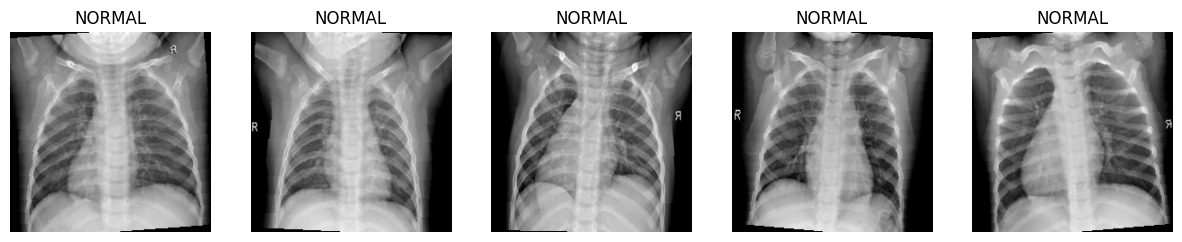

In [15]:
def show_batch(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, 5, figsize=(15,3))

    for i in range(5):
        img = denormalize(images[i])
        img = img.permute(1,2,0)
        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis("off")

    plt.show()

show_batch(train_loader_b0)

In [16]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def build_efficientnet_b0(num_classes=1, fine_tune=True):
    model = models.efficientnet_b0(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = False
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )

    if fine_tune:
        for param in model.features[-2:].parameters():
            param.requires_grad = True

    return model.to(device)

In [18]:
model_b0 = build_efficientnet_b0()
print(model_b0)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 179MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [19]:
criterion = nn.BCEWithLogitsLoss()

In [20]:
optimizer_b0 = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_b0.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)

In [21]:
scheduler_b0 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_b0,
    mode="min",
    patience=3,
    factor=0.3
)

In [22]:
NUM_EPOCHS = 15
BEST_MODEL_PATH = "outputs/models/efficientnet_b0_best.pth"

os.makedirs("outputs/models", exist_ok=True)

In [23]:
from sklearn.metrics import accuracy_score
def compute_accuracy(outputs, labels):
    probs = torch.sigmoid(outputs)
    preds = (probs >= 0.5).float()
    return accuracy_score(labels.cpu(), preds.cpu())

In [24]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()

    running_loss = 0.0
    running_acc = 0.0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc  += compute_accuracy(outputs, labels)

    epoch_loss = running_loss / len(loader)
    epoch_acc  = running_acc / len(loader)

    return epoch_loss, epoch_acc

In [25]:
def validate(model, loader, criterion):
    model.eval()

    running_loss = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            running_acc  += compute_accuracy(outputs, labels)

    epoch_loss = running_loss / len(loader)
    epoch_acc  = running_acc / len(loader)

    return epoch_loss, epoch_acc

In [26]:
best_val_loss = float("inf")

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

In [27]:
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model_b0, train_loader_b0, optimizer_b0, criterion
    )

    val_loss, val_acc = validate(
        model_b0, test_loader_b0, criterion
    )

    scheduler_b0.step(val_loss)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"""
Epoch [{epoch+1}/{NUM_EPOCHS}]
Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}
Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}
""")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_b0.state_dict(), BEST_MODEL_PATH)
        print("Best model saved")


Epoch [1/15]
Train Loss: 0.5418 | Train Acc: 0.7181
Val   Loss: 0.4798 | Val   Acc: 0.7781

Best model saved

Epoch [2/15]
Train Loss: 0.3183 | Train Acc: 0.9026
Val   Loss: 0.3371 | Val   Acc: 0.8719

Best model saved

Epoch [3/15]
Train Loss: 0.2117 | Train Acc: 0.9577
Val   Loss: 0.3465 | Val   Acc: 0.8609


Epoch [4/15]
Train Loss: 0.1855 | Train Acc: 0.9563
Val   Loss: 0.3306 | Val   Acc: 0.8609

Best model saved

Epoch [5/15]
Train Loss: 0.1578 | Train Acc: 0.9604
Val   Loss: 0.3107 | Val   Acc: 0.8719

Best model saved

Epoch [6/15]
Train Loss: 0.1364 | Train Acc: 0.9657
Val   Loss: 0.3040 | Val   Acc: 0.8750

Best model saved

Epoch [7/15]
Train Loss: 0.1176 | Train Acc: 0.9726
Val   Loss: 0.3026 | Val   Acc: 0.8703

Best model saved

Epoch [8/15]
Train Loss: 0.1163 | Train Acc: 0.9659
Val   Loss: 0.2891 | Val   Acc: 0.8891

Best model saved

Epoch [9/15]
Train Loss: 0.1203 | Train Acc: 0.9618
Val   Loss: 0.2866 | Val   Acc: 0.8891

Best model saved

Epoch [10/15]
Train Loss: 

In [28]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import seaborn as sns

In [29]:
model_b0.load_state_dict(torch.load(BEST_MODEL_PATH))
model_b0.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [30]:
y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for images, labels in test_loader_b0:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_b0(images)
        probs = torch.sigmoid(outputs).squeeze()

        preds = (probs >= 0.5).long()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

In [31]:
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)
auc  = roc_auc_score(y_true, y_prob)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")

Accuracy : 0.8878
Precision: 0.9278
Recall   : 0.8897
F1-score : 0.9084
ROC-AUC  : 0.9474


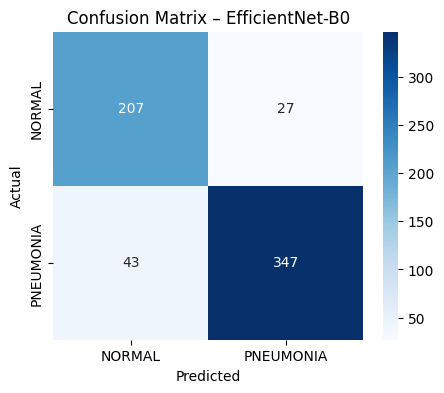

In [32]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – EfficientNet-B0")
plt.show()

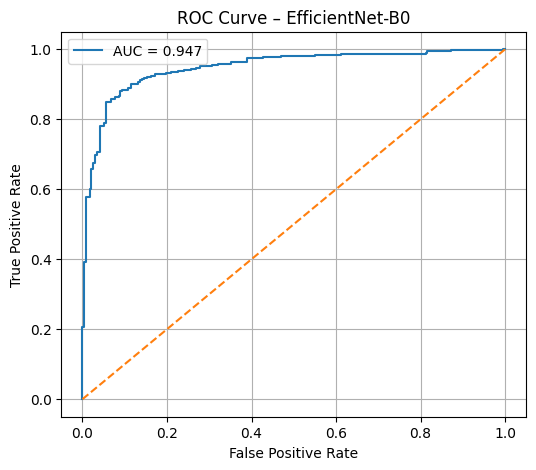

In [33]:
fpr, tpr, _ = roc_curve(y_true, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – EfficientNet-B0")
plt.legend()
plt.grid()
plt.show()


In [34]:
from torchvision import models
import torch.nn as nn

In [35]:
def build_efficientnet_b3(num_classes=1, fine_tune=True):
    model = models.efficientnet_b3(weights="IMAGENET1K_V1")

    for param in model.parameters():
        param.requires_grad = False

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )

    if fine_tune:
        for param in model.features[-3:].parameters():
            param.requires_grad = True

    return model.to(device)

In [36]:
model_b3 = build_efficientnet_b3()
print(model_b3)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 194MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [37]:
criterion = nn.BCEWithLogitsLoss()
optimizer_b3 = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_b3.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)
scheduler_b3 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_b3,
    mode="min",
    patience=3,
    factor=0.3
)

In [38]:
NUM_EPOCHS = 15
BEST_MODEL_PATH_B3 = "outputs/models/efficientnet_b3_best.pth"

best_val_loss = float("inf")

In [39]:
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model_b3, train_loader_b3, optimizer_b3, criterion
    )

    val_loss, val_acc = validate(
        model_b3, test_loader_b3, criterion
    )

    scheduler_b3.step(val_loss)

    print(f"""
Epoch [{epoch+1}/{NUM_EPOCHS}]
Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}
Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}
""")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_b3.state_dict(), BEST_MODEL_PATH_B3)
        print("Best B3 model saved")


Epoch [1/15]
Train Loss: 0.3710 | Train Acc: 0.8455
Val   Loss: 0.3014 | Val   Acc: 0.8814

Best B3 model saved

Epoch [2/15]
Train Loss: 0.1653 | Train Acc: 0.9530
Val   Loss: 0.2715 | Val   Acc: 0.8798

Best B3 model saved

Epoch [3/15]
Train Loss: 0.1095 | Train Acc: 0.9703
Val   Loss: 0.2573 | Val   Acc: 0.8958

Best B3 model saved

Epoch [4/15]
Train Loss: 0.0865 | Train Acc: 0.9746
Val   Loss: 0.2846 | Val   Acc: 0.8782


Epoch [5/15]
Train Loss: 0.0694 | Train Acc: 0.9839
Val   Loss: 0.2918 | Val   Acc: 0.8894


Epoch [6/15]
Train Loss: 0.0686 | Train Acc: 0.9796
Val   Loss: 0.2990 | Val   Acc: 0.8878


Epoch [7/15]
Train Loss: 0.0708 | Train Acc: 0.9790
Val   Loss: 0.3004 | Val   Acc: 0.8830


Epoch [8/15]
Train Loss: 0.0573 | Train Acc: 0.9833
Val   Loss: 0.2604 | Val   Acc: 0.8942


Epoch [9/15]
Train Loss: 0.0545 | Train Acc: 0.9839
Val   Loss: 0.2762 | Val   Acc: 0.8910


Epoch [10/15]
Train Loss: 0.0564 | Train Acc: 0.9833
Val   Loss: 0.3530 | Val   Acc: 0.8654


Epoch [1

In [40]:
model_b3.load_state_dict(torch.load(BEST_MODEL_PATH_B3))
model_b3.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [41]:
y_true_b3, y_pred_b3, y_prob_b3 = [], [], []

with torch.no_grad():
    for images, labels in test_loader_b3:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_b3(images)
        probs = torch.sigmoid(outputs).squeeze()
        preds = (probs >= 0.5).long()

        y_true_b3.extend(labels.cpu().numpy())
        y_pred_b3.extend(preds.cpu().numpy())
        y_prob_b3.extend(probs.cpu().numpy())

In [42]:
acc_b3  = accuracy_score(y_true_b3, y_pred_b3)
prec_b3 = precision_score(y_true_b3, y_pred_b3)
rec_b3  = recall_score(y_true_b3, y_pred_b3)
f1_b3   = f1_score(y_true_b3, y_pred_b3)
auc_b3  = roc_auc_score(y_true_b3, y_prob_b3)

print(f"Accuracy : {acc_b3:.4f}")
print(f"Precision: {prec_b3:.4f}")
print(f"Recall   : {rec_b3:.4f}")
print(f"F1-score : {f1_b3:.4f}")
print(f"ROC-AUC  : {auc_b3:.4f}")

Accuracy : 0.8958
Precision: 0.8916
Recall   : 0.9487
F1-score : 0.9193
ROC-AUC  : 0.9610


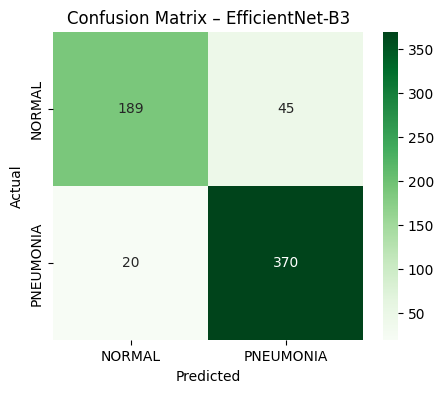

In [43]:
cm_b3 = confusion_matrix(y_true_b3, y_pred_b3)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_b3,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – EfficientNet-B3")
plt.show()

In [44]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"],
    "EfficientNet-B0": [acc, prec, rec, f1, auc],
    "EfficientNet-B3": [acc_b3, prec_b3, rec_b3, f1_b3, auc_b3]
})

comparison_df

,Metric,EfficientNet-B0,EfficientNet-B3
0,Accuracy,0.887821,0.895833
1,Precision,0.927807,0.891566
2,Recall,0.889744,0.948718
3,F1-score,0.908377,0.919255
4,ROC-AUC,0.947414,0.961012


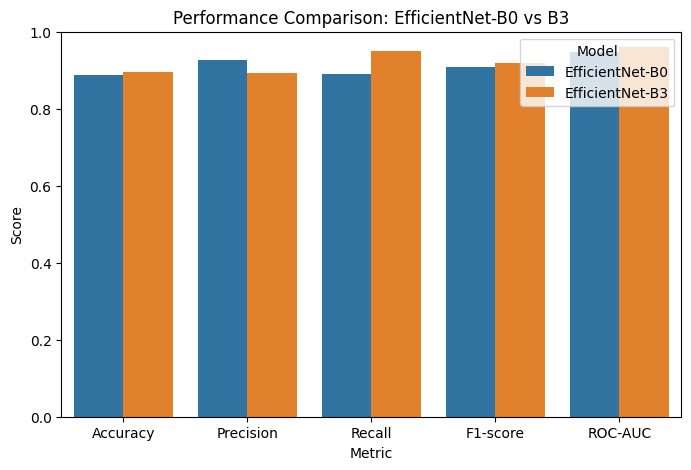

In [45]:
comparison_df_melt = comparison_df.melt(id_vars="Metric", var_name="Model", value_name="Score")

plt.figure(figsize=(8,5))
sns.barplot(x="Metric", y="Score", hue="Model", data=comparison_df_melt)
plt.title("Performance Comparison: EfficientNet-B0 vs B3")
plt.ylim(0,1)
plt.show()

In [46]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=b9dc41a54b95ea4ebb839fe0ab8ba1d70e106eb75bc8fa7524960d9fb38c72c6
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [47]:
import torch
import cv2
import os
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [48]:
def load_image_for_cam(img_path, transform):
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)
    rgb_img = np.array(img.resize((input_tensor.shape[-1], input_tensor.shape[-1]))) / 255.0
    return input_tensor, rgb_img


In [53]:
def generate_gradcam(
    model,
    target_layer,
    img_path,
    transform,
    save_path,
    title=None
):
    model.eval()

    input_tensor, rgb_img = load_image_for_cam(img_path, transform)

    cam = GradCAM(
        model=model,
        target_layers=[target_layer]
    )

    grayscale_cam = cam(
        input_tensor=input_tensor
    )[0]

    visualization = show_cam_on_image(
        rgb_img,
        grayscale_cam,
        use_rgb=True
    )

    plt.figure(figsize=(4, 4))
    plt.imshow(visualization)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()


In [64]:
import os

NORMAL_IMG = "data/chest_xray/test/NORMAL/IM-0001-0001.jpeg"
PNEUMONIA_IMG = "data/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg"
os.makedirs("IMG", exist_ok=True)


In [65]:
from torchvision import transforms

transform_b0 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
transform_b3 = transforms.Compose([
    transforms.Resize((300, 300)),   # B3 input size
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


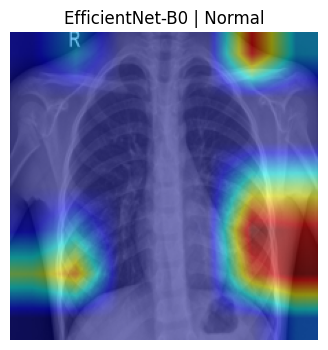

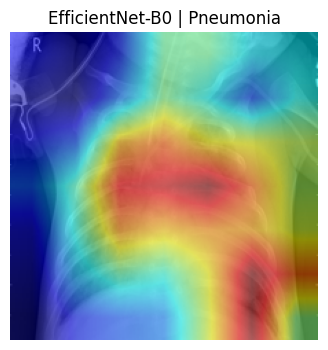

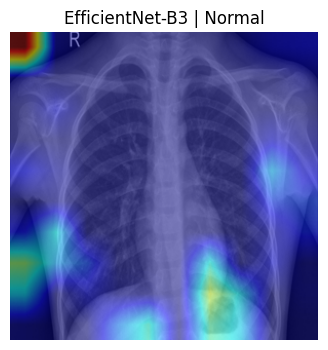

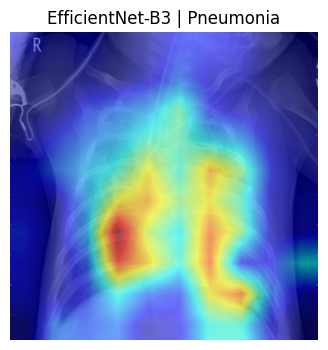

In [66]:
target_layer_b0 = model_b0.features[-1]

generate_gradcam(
    model_b0,
    target_layer_b0,
    NORMAL_IMG,
    transform_b0,
    save_path="IMG/gradcam_b0_normal.png",
    title="EfficientNet-B0 | Normal"
)

generate_gradcam(
    model_b0,
    target_layer_b0,
    PNEUMONIA_IMG,
    transform_b0,
    save_path="IMG/gradcam_b0_pneumonia.png",
    title="EfficientNet-B0 | Pneumonia"
)
target_layer_b3 = model_b3.features[-1]

generate_gradcam(
    model_b3,
    target_layer_b3,
    NORMAL_IMG,
    transform_b3,
    save_path="IMG/gradcam_b3_normal.png",
    title="EfficientNet-B3 | Normal"
)

generate_gradcam(
    model_b3,
    target_layer_b3,
    PNEUMONIA_IMG,
    transform_b3,
    save_path="IMG/gradcam_b3_pneumonia.png",
    title="EfficientNet-B3 | Pneumonia"
)


In [67]:
import matplotlib.pyplot as plt
from PIL import Image

def compare_gradcam_b0_b3(
    img_b0_normal,
    img_b0_pneumonia,
    img_b3_normal,
    img_b3_pneumonia,
    save_path
):
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    images = [
        (img_b0_normal, "B0 | Normal"),
        (img_b3_normal, "B3 | Normal"),
        (img_b0_pneumonia, "B0 | Pneumonia"),
        (img_b3_pneumonia, "B3 | Pneumonia"),
    ]

    for ax, (img_path, title) in zip(axs.flatten(), images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


In [69]:
def evaluate_model(model, dataloader, device):
    model.eval()

    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze()
            preds = (probs > 0.5).int()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_prob)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_b0.to(device)

y_true_b0, y_pred_b0, y_prob_b0 = evaluate_model(
    model_b0,
    test_loader_b0,
    device
)
model_b3.to(device)

y_true_b3, y_pred_b3, y_prob_b3 = evaluate_model(
    model_b3,
    test_loader_b3,
    device
)

In [70]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score

acc_b0 = accuracy_score(y_true_b0, y_pred_b0)
recall_b0 = recall_score(y_true_b0, y_pred_b0)
f1_b0 = f1_score(y_true_b0, y_pred_b0)
auc_b0 = roc_auc_score(y_true_b0, y_prob_b0)

acc_b0, recall_b0, f1_b0, auc_b0

(0.8878205128205128,
 0.8897435897435897,
 0.9083769633507853,
 np.float64(0.9474139820293667))

In [71]:
acc_b3 = accuracy_score(y_true_b3, y_pred_b3)
recall_b3 = recall_score(y_true_b3, y_pred_b3)
f1_b3 = f1_score(y_true_b3, y_pred_b3)
auc_b3 = roc_auc_score(y_true_b3, y_prob_b3)

acc_b3, recall_b3, f1_b3, auc_b3


(0.8958333333333334,
 0.9487179487179487,
 0.9192546583850931,
 np.float64(0.9610124917817225))

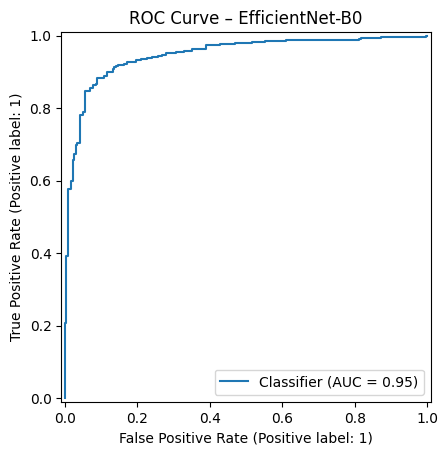

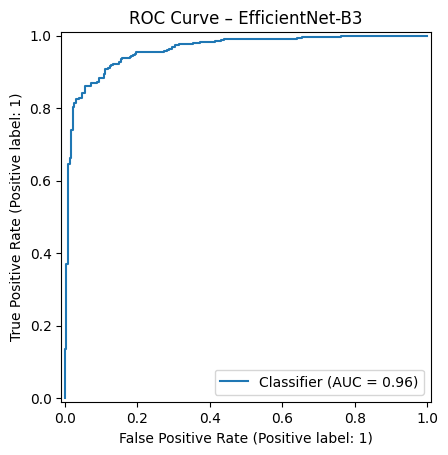

In [72]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(
    y_true_b0,
    y_prob_b0
)

plt.title("ROC Curve – EfficientNet-B0")
plt.savefig("outputs/figures/roc_b0.png", dpi=300)
plt.show()
RocCurveDisplay.from_predictions(
    y_true_b3,
    y_prob_b3
)

plt.title("ROC Curve – EfficientNet-B3")
plt.savefig("outputs/figures/roc_b3.png", dpi=300)
plt.show()


In [73]:
import pandas as pd
import os

os.makedirs("outputs/metrics", exist_ok=True)

results = [
    {
        "Model": "EfficientNet-B0",
        "Accuracy": acc_b0,
        "Recall": recall_b0,
        "F1-Score": f1_b0,
        "AUC": auc_b0
    },
    {
        "Model": "EfficientNet-B3",
        "Accuracy": acc_b3,
        "Recall": recall_b3,
        "F1-Score": f1_b3,
        "AUC": auc_b3
    }
]

df = pd.DataFrame(results)
df.to_csv("outputs/metrics/final_results.csv", index=False)
df


,Model,Accuracy,Recall,F1-Score,AUC
0,EfficientNet-B0,0.887821,0.889744,0.908377,0.947414
1,EfficientNet-B3,0.895833,0.948718,0.919255,0.961012


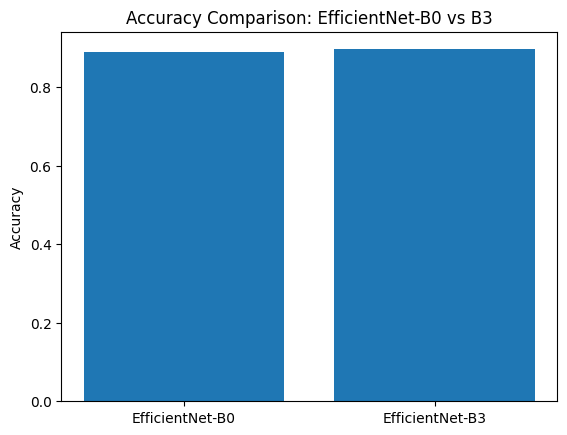

In [74]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(df["Model"], df["Accuracy"])
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: EfficientNet-B0 vs B3")
plt.savefig("outputs/figures/accuracy_comparison.png", dpi=300)
plt.show()

Thank you for taking the time to explore this project, run the code, and review the implementation.  
Your feedback, suggestions, and contributions are greatly appreciated and can help improve this project.
 follow me on...

Linkedin : www.linkedin.com/in/ali-mohamaadpour